# Incremental Representation for Parsing

In [3]:
import sys
sys.path.append("../src")
import numpy as np
import nltk
from nltk.tree import Tree
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
from iparse_vq import IParser
import evaluate
import torch
import torch_struct

Chỉnh lightmode nếu xem notebook bằng Github web

Github link with web demo, report, notebook: [locluclak/Demo-Incremental-Representation-Parsing](https://github.com/locluclak/Demo-Incremental-Representation-Parsing)

## Load model

Model: [Parser Models](https://github.com/thomaslu2000/Incremental-Parsing-Representations/releases/tag/Initial-Release) 
Cấu trúc Mô hình (Bottleneck: 32 tags)
- **Encoder (GPT-2)**: Sử dụng cơ chế tự hồi quy (autoregressive) để xử lý văn bản từ trái sang phải. Trạng thái ẩn của mỗi từ được nén qua lớp Information Bottleneck thành một tag rời rạc (trong bảng mã 32 giá trị), giúp cô đọng thông tin cú pháp trọng tâm.

- **Readout Network**: Tiếp nhận chuỗi tags để tái tạo cây cú pháp. Thành phần này kết hợp Transformer + MLP để tính điểm các tag dựa trên ngữ cảnh toàn cục, sau đó dùng thuật toán Span-Based CKY để tối ưu hóa và xuất ra cấu trúc cây hoàn chỉnh.

In [4]:
iparse = IParser("../32_model")
dev_treebank = iparse.load_dev()


In [5]:
dev_predicted_and_cats, encoded = iparse.parser.parse(
    dev_treebank.without_gold_annotations(),
    subbatch_max_tokens=500,
    tau=0.0,
    return_cats=True,
    return_encoded=True
)

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/loc/anaconda3/envs/nlp/lib/python3.11/site-packages/torch/distributions/distribution.py:62: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


### Ví dụ 1:

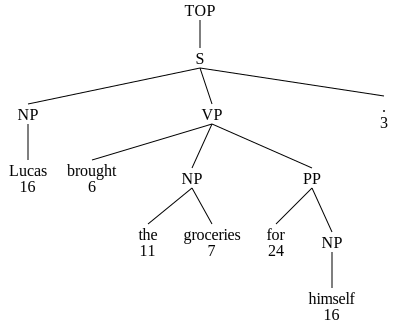

In [6]:
t, c = iparse.parse_sentence("Lucas brought the groceries for himself .")
t

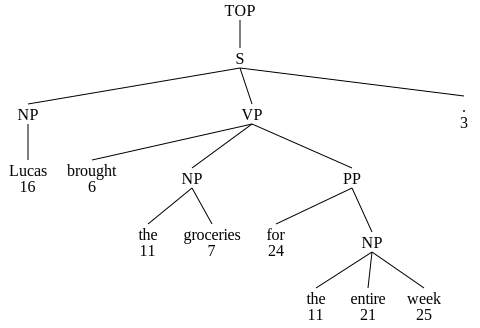

In [27]:
t, c = iparse.parse_sentence("Lucas brought the groceries for the entire week .")
t

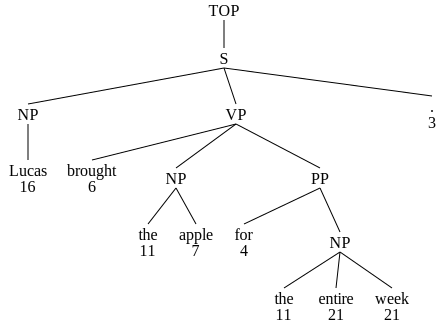

In [28]:
t, c = iparse.parse_sentence("Lucas brought the apple for the entire week .")
t

Tag symbol của từ `for` không thay đổi (= 24) kể  cả khi vế sau thay đổi

Nhưng khi các từ ngữ phía trước thay đổi, tag symbol của `for` lại = 4

--> Cho thấy tag chỉ phụ thuộc thông tin vào những từ phía trước, không phải các từ phía sau của từ đó.


Các từ feed qua encoder (GPT2) được chuyển thành các discrete token có giá trị 1 -> 32

In [23]:
from benepar import Parser, InputSentence

words = "Lucas brought the groceries for himself ."

words = words.split()

inputs = [InputSentence(words=words)]
inputs = [iparse.nltk_wrapper._with_missing_fields_filled(
    x) for x in inputs]
_, cats = iparse.parser.parse(
            inputs, return_cats=True)[0]

cats

array([16,  6, 11,  7, 24, 16,  3])

Build parsing tree từ câu biểu diễn bằng discrete tokens 

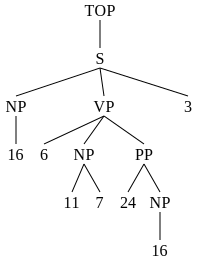

In [8]:
iparse.tree_from_cats([16,  6, 11,  7, 24, 16,  3])


### Ví dụ 2:
Thử  câu dài và phức tạp hơn.

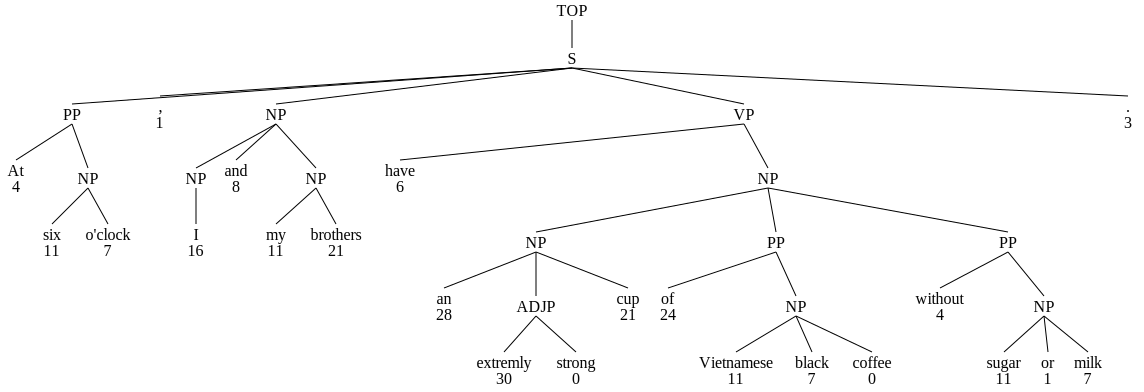

In [9]:
t, c = iparse.parse_sentence("At six o'clock , I and my brothers have an extremly strong cup of Vietnamese black coffee without sugar or milk .")
t

### Ví dụ khi đối mặt với từ còn mơ hồ .
The Council approved the proposal on ... (từ 'on' là mơ hồ  do còn phải phụ thuộc vào từ phía sau)
- Monday .
- taxes .

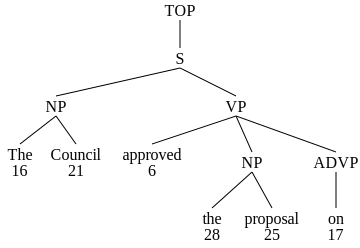

In [10]:
t, c = iparse.parse_sentence("The Council approved the proposal on")
t

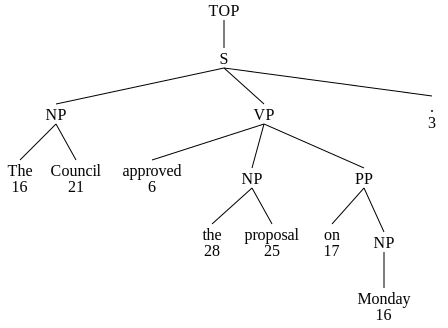

In [11]:
t, c = iparse.parse_sentence("The Council approved the proposal on Monday .")
t

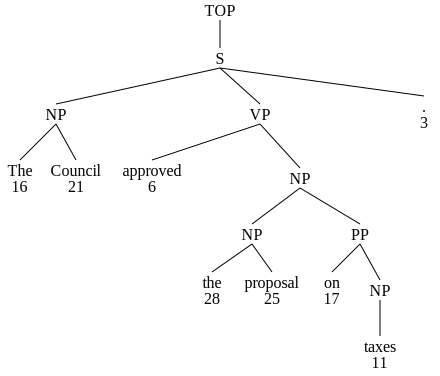

In [12]:
t, c = iparse.parse_sentence("The Council approved the proposal on taxes .")
t

Ví dụ này minh họa khả năng của mô hình trong việc duy trì một chuỗi nhãn duy nhất nhưng vẫn linh hoạt thay đổi cấu trúc cây dựa trên ngữ cảnh xuất hiện sau đó.

## Evaluation

### Load data

Mô hình được đánh giá trên tập Section 23 thuộc bộ dữ liệu Penn Treebank (Wall Street Journal - WSJ).

Dữ liệu `/data/23.auto.clean` được xử lý với mỗi dòng là gold tree.

In [ ]:
from nltk.tree import Tree

# 1. Load toàn bộ vào list
with open('../data/23.auto.clean', 'r') as f:
    all_trees = [Tree.fromstring(line.strip()) for line in f if line.strip()]



In [ ]:
print("Samples size",len(all_trees))

Samples size 2416


In [ ]:
def xem_cay(stt):
    if 1 <= stt <= len(all_trees):
        print(f"Cây thứ {stt}:")
        all_trees[stt-1].pretty_print()
    else:
        print("error")
xem_cay(1)

In [ ]:
xem_cay(2)

Cây thứ 2:
                                                                                                               TOP                                                                                                                             
                                                                                                                |                                                                                                                               
                                                                                                                S                                                                                                                              
  ______________________________________________________________________________________________________________|____________________________________________________________________________________________________________________________   
 |                         

In [ ]:
!python ../src/main.py test --model-path ../32_model --test-path ../data/23.auto.clean --subbatch-max-tokens 750 --evalb-dir ../EVALB/


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading test trees from ../data/23.auto.clean...
Loaded 2,416 test examples.
Loading model from ../32_model...
/home/loc/anaconda3/envs/nlp/lib/python3.11/site-packages/torch/cuda/__init__.py:182: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:119.)
  return torch._C._cuda_getDeviceCount() > 0
Parsing test sentences...
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/home/loc/anaconda3/envs/nlp/lib/python3.11/site-packages/torch/distributions/distribution.py:62: UserWarning: <class 'torch_struct.distributions.TreeCRF'> does not define `arg_constraints`. Please set `arg_constraints 

- Hiệu quả nén tối ưu: Với chỉ 32 nhãn, mô hình đạt F1 93.72, chứng minh thông tin cú pháp phức tạp có thể được nén cực gọn vào một bảng mã nhỏ mà vẫn duy trì độ chính xác cao.

- Độ tin cậy của dự đoán (Precision 94.37 vs Recall 93.09): Chỉ số Precision cao hơn Recall cho thấy các cấu trúc cú pháp mà mô hình xác định có độ tin cậy lớn, ít xảy ra tình trạng gán sai các quan hệ ngữ pháp.

- Khả năng tái cấu trúc tổng quát: Dù bị giới hạn thông tin và xử lý tăng tiến, tỷ lệ Complete Match 45.36%. Complete Match tính bằng cách: một câu được tính là "Complete Match" chỉ khi toàn bộ cấu trúc cây cú pháp mà mô hình tạo ra khớp chính xác 100% với cây chuẩn (Gold tree)